
# Predictive Maintenance (AI4I 2020, UCI) — PRO Notebook
**What you get**
- **Model 1 (Binary):** Predict `Machine failure` with Logistic Regression, Random Forest, Gradient Boosting  
  - Precision–Recall curves, **AP**, **best F2 threshold**, **cost-sensitive threshold**  
  - **Calibration** (CalibratedClassifierCV) for the best model  
  - **Permutation feature importance** + top features plot  
  - Saves `binary_model_summary.csv` and best model as `model1_best.joblib`
- **Model 2 (Multi-class):** Classify failure type (`TWF/HDF/PWF/OSF/RNF`) on single-mode failure rows  
  - Decision Tree, Linear SVM, GaussianNB, (optional) XGBoost  
  - Per-class F1, macro-F1, confusion matrices  
  - Label encoding fix + class map displayed  
  - Saves `multiclass_model_summary.csv`, label encoder & best model


In [1]:

# --- Setup & installs
import sys, subprocess, importlib

def ensure(pkg_spec, import_name=None):
    name = (import_name or pkg_spec.split("==")[0]).replace("-", "_")
    try:
        importlib.import_module(name)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_spec])

ensure("pandas"); ensure("numpy"); ensure("scikit-learn","sklearn")
ensure("matplotlib"); ensure("ucimlrepo"); ensure("joblib")
# Optional: xgboost, imbalanced-learn
try:
    import xgboost  # noqa
except Exception:
    try: ensure("xgboost")
    except Exception as e: print("Warning: XGBoost not available:", e)
try:
    import imblearn  # noqa
except Exception:
    try: ensure("imbalanced-learn")
    except Exception as e: print("Warning: imbalanced-learn not available:", e)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, f1_score, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from joblib import dump

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



## 1) Load dataset (AI4I 2020, UCI)
Tries `ucimlrepo` (id=601), then direct UCI CSV, then local `ai4i2020.csv` if present.


In [3]:

df = None; errors = []
try:
    from ucimlrepo import fetch_ucirepo
    ds = fetch_ucirepo(id=601)  # AI4I 2020 Predictive Maintenance
    X = ds.data.features; y = ds.data.targets
    df = pd.concat([X, y], axis=1)
    print("Loaded via ucimlrepo (601). Shape:", df.shape)
except Exception as e:
    errors.append(f"ucimlrepo failed: {e}")

if df is None:
    try:
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
        df = pd.read_csv(url)
        print("Loaded via direct URL. Shape:", df.shape)
    except Exception as e:
        errors.append(f"URL failed: {e}")

if df is None:
    p = Path("ai4i2020.csv")
    if p.exists():
        df = pd.read_csv(p); print("Loaded local CSV. Shape:", df.shape)
    else:
        raise RuntimeError("Could not load dataset.\n" + "\n".join(errors))

df.columns = [c.strip() for c in df.columns]
display(df.head(3))
print("Columns:", list(df.columns))


Loaded via ucimlrepo (601). Shape: (10000, 12)


,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


Columns: ['Type', 'Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']



## 2) EDA — Imbalance & Sensors


Class distribution (Machine failure):
 Machine failure
0    9661
1     339
Name: count, dtype: int64

Failure-mode flags sum:
TWF: 46
HDF: 115
PWF: 95
OSF: 98
RNF: 19


C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_18080\3314796324.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(corr, interpolation='nearest')
C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_18080\3314796324.py:27: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(corr, interpolation='nearest')


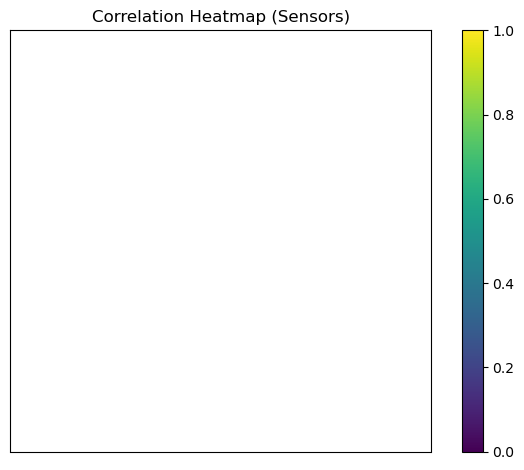

In [4]:

# Identify key columns
machine_failure_col = None
for cand in ["Machine failure","machine failure","machine_failure","failure","Failure"]:
    if cand in df.columns: machine_failure_col = cand; break
if machine_failure_col is None:
    raise KeyError("Machine failure column not found.")

failure_cols = [c for c in ["TWF","HDF","PWF","OSF","RNF"] if c in df.columns]
sensor_cols = [c for c in ["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]"] if c in df.columns]
cat_cols = [c for c in ["Type"] if c in df.columns]

print("Class distribution (Machine failure):\n", df[machine_failure_col].value_counts(dropna=False).sort_index())
print("\nFailure-mode flags sum:")
for c in failure_cols: print(f"{c}: {int(df[c].sum())}")

# Histograms
for col in sensor_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.show()

# Correlation
corr = df[sensor_cols].corr(numeric_only=True)
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(sensor_cols)), sensor_cols, rotation=45, ha='right')
plt.yticks(range(len(sensor_cols)), sensor_cols)
plt.title("Correlation Heatmap (Sensors)")
plt.colorbar()
plt.tight_layout(); plt.show()



## 3) Feature Engineering
- `TempDiff = Process - Air`  
- `TorqueRPM = Torque * Rotational speed` (proxy load)  
- Quadratic terms: `Torque^2`, `RPM^2`


In [5]:
df_fe = df.copy()

def _norm(s):
    return ''.join(ch for ch in str(s).lower() if ch.isalnum())

col_norm_map = { _norm(c): c for c in df_fe.columns }

def _pick(*aliases):
    for a in aliases:
        key = _norm(a)
        if key in col_norm_map:
            return col_norm_map[key]
    return None

# Try to resolve expected sensor columns with multiple aliases
col_air   = _pick('Air temperature [K]', 'air temperature', 'air_temp_k', 'airtemp')
col_proc  = _pick('Process temperature [K]', 'process temperature', 'proc_temp_k', 'processtemp')
col_rpm   = _pick('Rotational speed [rpm]', 'rotational speed', 'rpm', 'speed_rpm')
col_torque= _pick('Torque [Nm]', 'torque', 'torque_nm')
col_wear  = _pick('Tool wear [min]', 'tool wear', 'tool_wear_min')

# Ensure sensor_cols and cat_cols exist even if earlier cells weren't run
sensor_cols = [c for c in [col_air, col_proc, col_rpm, col_torque, col_wear] if c]
if 'cat_cols' not in globals():
    col_type = _pick('Type', 'type')
    cat_cols = [col_type] if col_type else []

# Create engineered features if base columns are found
engineered_cols = []

if col_proc and col_air:
    df_fe['TempDiff'] = df_fe[col_proc] - df_fe[col_air]
    engineered_cols.append('TempDiff')

if col_torque and col_rpm:
    df_fe['TorqueRPM'] = df_fe[col_torque] * df_fe[col_rpm]
    engineered_cols.append('TorqueRPM')

if col_torque:
    df_fe['Torque2'] = df_fe[col_torque] ** 2
    engineered_cols.append('Torque2')

if col_rpm:
    df_fe['RPM2'] = df_fe[col_rpm] ** 2
    engineered_cols.append('RPM2')

# Final numeric feature list (sensors + engineered)
num_features_all = list(dict.fromkeys(sensor_cols + engineered_cols))

print("Resolved columns ->")
print("  Air:   ", col_air)
print("  Proc:  ", col_proc)
print("  RPM:   ", col_rpm)
print("  Torque:", col_torque)
print("  Wear:  ", col_wear)
print("Engineered features:", engineered_cols)
print("Total numeric features:", len(num_features_all))


Resolved columns ->
  Air:    Air temperature
  Proc:   Process temperature
  RPM:    Rotational speed
  Torque: Torque
  Wear:   Tool wear
Engineered features: ['TempDiff', 'TorqueRPM', 'Torque2', 'RPM2']
Total numeric features: 9



## 4) Model 1 — Failure Prediction (Binary) with Threshold Tuning & Calibration
Primary objective: **catch failures** → focus on PR curve, AP, and **F2**.  
We'll also compute a **cost-weighted threshold** (set `COST_FN` vs `COST_FP`).


In [7]:
# Prepare data
X1 = df_fe[num_features_all + cat_cols].copy()
y1 = df_fe[machine_failure_col].astype(int).copy()

X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, stratify=y1, random_state=RANDOM_STATE
)

prep_lr = ColumnTransformer([
    ("num", StandardScaler(), num_features_all),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])
prep_tree = ColumnTransformer([
    ("num", "passthrough", num_features_all),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

models_bin = {
    "LogReg": Pipeline([("prep", prep_lr), ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))]),
    "RandomForest": Pipeline([("prep", prep_tree), ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1))]),
    "GradBoost": Pipeline([("prep", prep_tree), ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))]),
}

In [8]:
def fbeta_point(p, r, beta=2.0):
    if p + r == 0: return 0.0
    b2 = beta**2
    return (1+b2)*(p*r)/(b2*p + r)

COST_FP = 1.0
COST_FN = 5.0  # missing a failure is ~5x worse than a false alarm

def best_thresholds_from_scores(y_true, scores):
    prec, rec, thr = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)
    # Best F2
    best_f2, best_thr_f2, bp, br = 0.0, 0.5, 0.0, 0.0
    for p, r, t in zip(prec[:-1], rec[:-1], thr):
        f2 = fbeta_point(p, r, 2.0)
        if f2 > best_f2:
            best_f2, best_thr_f2, bp, br = f2, t, p, r
    # Best cost
    # Approximate expected cost for each threshold via confusion estimates
    # Convert scores at each threshold
    best_cost, best_thr_cost = float("inf"), 0.5
    for t in thr:
        y_pred = (scores >= t).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        cost = COST_FP * fp + COST_FN * fn
        if cost < best_cost:
            best_cost, best_thr_cost = cost, t
    return ap, (best_f2, best_thr_f2, bp, br), (best_cost, best_thr_cost), (prec, rec, thr)


=== LogReg @ F2-opt threshold=0.7657 ===
Confusion:
 [[1843   89]
 [  16   52]]
Report:
               precision    recall  f1-score   support

           0      0.991     0.954     0.972      1932
           1      0.369     0.765     0.498        68

    accuracy                          0.948      2000
   macro avg      0.680     0.859     0.735      2000
weighted avg      0.970     0.948     0.956      2000


=== LogReg @ Cost-opt threshold=0.8222 ===
Confusion:
 [[1870   62]
 [  21   47]]
Report:
               precision    recall  f1-score   support

           0      0.989     0.968     0.978      1932
           1      0.431     0.691     0.531        68

    accuracy                          0.959      2000
   macro avg      0.710     0.830     0.755      2000
weighted avg      0.970     0.959     0.963      2000


=== RandomForest @ F2-opt threshold=0.3275 ===
Confusion:
 [[1926    6]
 [  12   56]]
Report:
               precision    recall  f1-score   support

           0 

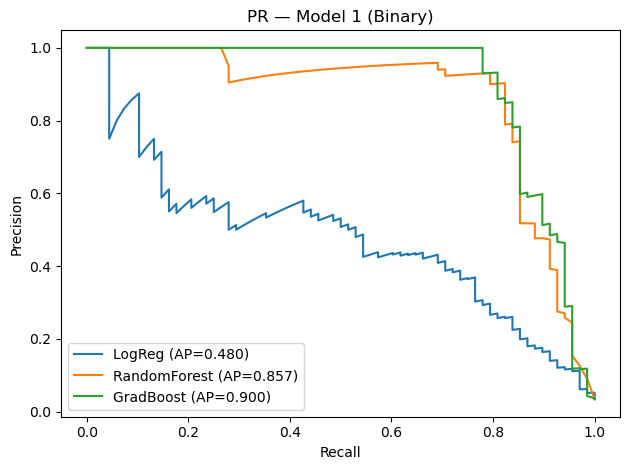

,Model,AP,BestF2,Thr_F2,P@F2,R@F2,Cost,Thr_Cost
2,GradBoost,0.899795,0.840708,0.249641,0.850746,0.838235,65.0,0.249641
1,RandomForest,0.856930,0.838323,0.327500,0.903226,0.823529,66.0,0.327500
0,LogReg,0.480206,0.629540,0.765707,0.368794,0.764706,167.0,0.822195


Saved: binary_model_summary.csv
Best binary model: GradBoost


In [9]:
summary_rows = []
plt.figure()
for name, pipe in models_bin.items():
    pipe.fit(X1_train, y1_train)
    # Probabilities
    try:
        scores = pipe.predict_proba(X1_test)[:,1]
    except Exception:
        scores = pipe.decision_function(X1_test)
        m, M = scores.min(), scores.max()
        scores = (scores - m)/(M-m) if M>m else np.zeros_like(scores)

    ap, bestF2_pack, bestCost_pack, (prec, rec, thr) = best_thresholds_from_scores(y1_test, scores)
    bestF2, thrF2, pF2, rF2 = bestF2_pack
    bestCost, thrCost = bestCost_pack

    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

    # Evaluate at cost-optimal threshold
    for label, thr_use in [("F2-opt", thrF2), ("Cost-opt", thrCost)]:
        y_pred = (scores >= thr_use).astype(int)
        cm = confusion_matrix(y1_test, y_pred, labels=[0,1])
        print(f"\n=== {name} @ {label} threshold={thr_use:.4f} ===")
        print("Confusion:\n", cm)
        print("Report:\n", classification_report(y1_test, y_pred, digits=3))

    summary_rows.append({
        "Model": name, "AP": ap,
        "BestF2": bestF2, "Thr_F2": thrF2, "P@F2": pF2, "R@F2": rF2,
        "Cost": bestCost, "Thr_Cost": thrCost
    })

plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR — Model 1 (Binary)")
plt.legend(); plt.tight_layout(); plt.show()

summary_bin = pd.DataFrame(summary_rows).sort_values(["AP","BestF2"], ascending=False)
display(summary_bin)
summary_bin.to_csv("binary_model_summary.csv", index=False)
print("Saved: binary_model_summary.csv")

best_bin_model_name = summary_bin.iloc[0]["Model"]
best_bin_model = models_bin[best_bin_model_name]
print("Best binary model:", best_bin_model_name)


In [10]:
# --- Calibration on the best model ---
calibrated = CalibratedClassifierCV(best_bin_model, cv=3, method="sigmoid")
calibrated.fit(X1_train, y1_train)
cal_scores = calibrated.predict_proba(X1_test)[:,1]
cal_ap = average_precision_score(y1_test, cal_scores)
print(f"Calibrated {best_bin_model_name} AP={cal_ap:.4f} (vs uncalibrated {summary_bin.iloc[0]['AP']:.4f})")

# Save calibrated best model
dump(calibrated, "model1_best.joblib")
print("Saved: model1_best.joblib")


Calibrated GradBoost AP=0.9025 (vs uncalibrated 0.8998)
Saved: model1_best.joblib



## 6) Model 2 — Failure Type (Multi-class) with Label Encoding
Use only rows where `Machine failure==1` **and** exactly one failure mode flag is 1.  
Encodes class labels → integers for stable training across libraries.


In [12]:
# Filter to single-mode failures
failed = df_fe[df_fe[machine_failure_col] == 1].copy()
failed["num_active_modes"] = failed[failure_cols].sum(axis=1)
single_mode = failed[failed["num_active_modes"] == 1].copy()
single_mode["failure_type"] = single_mode[failure_cols].idxmax(axis=1)

print(f"Failed rows: {len(failed)} | Single-mode used: {len(single_mode)} | Dropped: {len(failed)-len(single_mode)}")
print("Class counts (string):\n", single_mode["failure_type"].value_counts())

Failed rows: 339 | Single-mode used: 306 | Dropped: 33
Class counts (string):
 failure_type
HDF    106
PWF     80
OSF     78
TWF     42
Name: count, dtype: int64


In [13]:
# Features & labels
X2 = single_mode[num_features_all + cat_cols].copy()
le = LabelEncoder()
y2 = le.fit_transform(single_mode["failure_type"].astype(str))
class_names = list(le.classes_)
print("Label mapping:", {name:i for i,name in enumerate(class_names)})

Label mapping: {'HDF': 0, 'OSF': 1, 'PWF': 2, 'TWF': 3}



=== DecisionTree ===
Macro-F1: 0.9340
              precision    recall  f1-score   support

         HDF      0.913     1.000     0.955        21
         OSF      1.000     0.812     0.897        16
         PWF      0.938     0.938     0.938        16
         TWF      0.900     1.000     0.947         9

    accuracy                          0.935        62
   macro avg      0.938     0.938     0.934        62
weighted avg      0.940     0.935     0.934        62



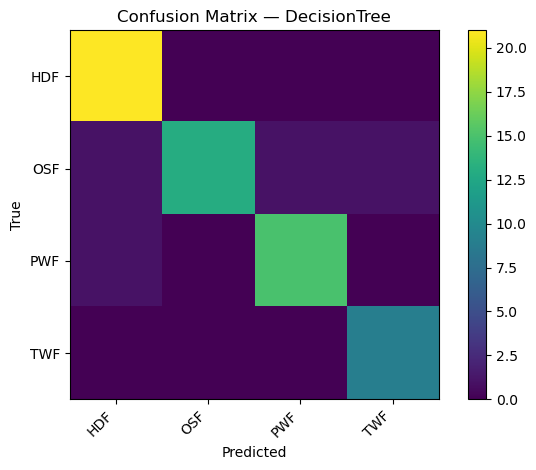


=== SVM-linear ===
Macro-F1: 0.9312
              precision    recall  f1-score   support

         HDF      0.947     0.857     0.900        21
         OSF      1.000     1.000     1.000        16
         PWF      1.000     0.938     0.968        16
         TWF      0.750     1.000     0.857         9

    accuracy                          0.935        62
   macro avg      0.924     0.949     0.931        62
weighted avg      0.946     0.935     0.937        62



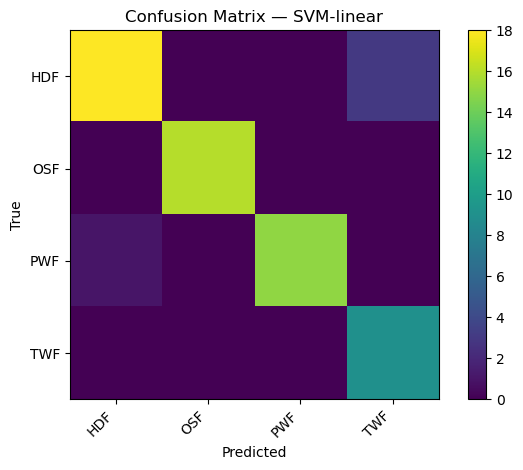


=== GaussianNB ===
Macro-F1: 0.8963
              precision    recall  f1-score   support

         HDF      0.913     1.000     0.955        21
         OSF      0.929     0.812     0.867        16
         PWF      0.875     0.875     0.875        16
         TWF      0.889     0.889     0.889         9

    accuracy                          0.903        62
   macro avg      0.901     0.894     0.896        62
weighted avg      0.904     0.903     0.902        62



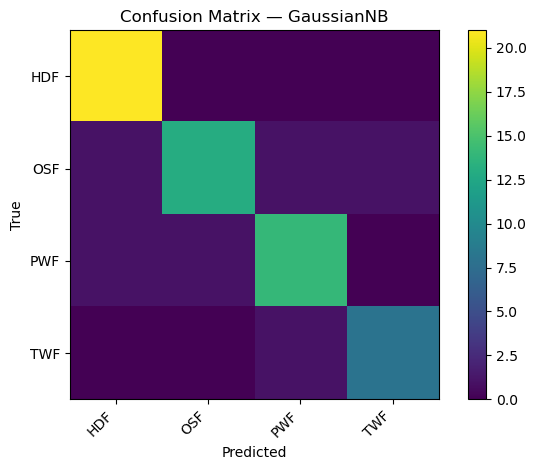


=== XGBoost ===
Macro-F1: 0.9644
              precision    recall  f1-score   support

         HDF      0.955     1.000     0.977        21
         OSF      1.000     0.875     0.933        16
         PWF      1.000     1.000     1.000        16
         TWF      0.900     1.000     0.947         9

    accuracy                          0.968        62
   macro avg      0.964     0.969     0.964        62
weighted avg      0.970     0.968     0.967        62



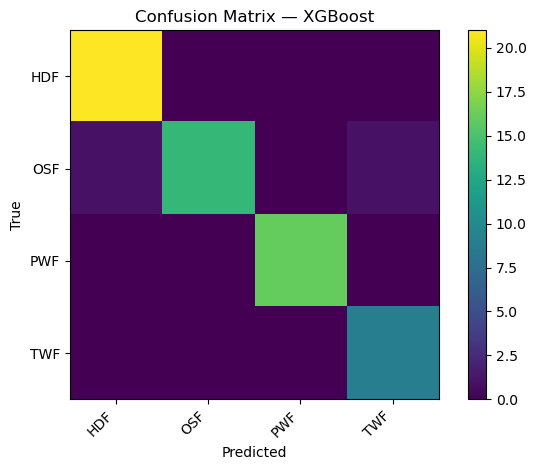

,Model,MacroF1
3,XGBoost,0.964361
0,DecisionTree,0.933991
1,SVM-linear,0.931221
2,GaussianNB,0.896275


Saved: multiclass_model_summary.csv
Best multi-class model: XGBoost


In [17]:




# Split (guard: if stratify fails due to tiny classes, fall back)
try:
    X2_train, X2_test, y2_train, y2_test = train_test_split(
        X2, y2, test_size=0.2, random_state=RANDOM_STATE, stratify=y2
    )
except Exception as e:
    print("Stratified split failed, falling back to random split:", e)
    X2_train, X2_test, y2_train, y2_test = train_test_split(
        X2, y2, test_size=0.2, random_state=RANDOM_STATE
    )

prep_common = ColumnTransformer([
    ("num", StandardScaler(), num_features_all),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

models_multi = {
    "DecisionTree": Pipeline([("prep", prep_common), ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))]),
    "SVM-linear":   Pipeline([("prep", prep_common), ("clf", SVC(kernel="linear", class_weight="balanced", random_state=RANDOM_STATE))]),
    "GaussianNB":   Pipeline([
        ("prep", ColumnTransformer([
            ("num", StandardScaler(), num_features_all),
            ("cat", OneHotEncoder(sparse_output=False), cat_cols),
        ], remainder="drop")),
        ("clf", GaussianNB())
    ]),
}

# XGBoost
try:
    from xgboost import XGBClassifier
    models_multi["XGBoost"] = Pipeline([
        ("prep", prep_common),
        ("clf", XGBClassifier(
            objective="multi:softmax",
            num_class=len(class_names),
            eval_metric="mlogloss",
            tree_method="hist",
            n_estimators=400, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8,
            random_state=RANDOM_STATE
        ))
    ])
except Exception as e:
    print("XGBoost not available; skipping:", e)

def eval_multi(name, pipe):
    pipe.fit(X2_train, y2_train)
    y_pred = pipe.predict(X2_test)
    macro_f1 = f1_score(y2_test, y_pred, average="macro")
    print(f"\n=== {name} ===\nMacro-F1: {macro_f1:.4f}")
    print(classification_report(y2_test, y_pred, digits=3, target_names=class_names))
    cm = confusion_matrix(y2_test, y_pred, labels=list(range(len(class_names))))
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix — {name}")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.yticks(range(len(class_names)), class_names)
    plt.colorbar(); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()
    return {"Model": name, "MacroF1": macro_f1}

summary_multi = []
for name, model in models_multi.items():
    summary_multi.append(eval_multi(name, model))

summary_multi = pd.DataFrame(summary_multi).sort_values("MacroF1", ascending=False)
display(summary_multi)
summary_multi.to_csv("multiclass_model_summary.csv", index=False)
print("Saved: multiclass_model_summary.csv")

best_multi_name = summary_multi.iloc[0]["Model"]
best_multi_model = models_multi[best_multi_name]
print("Best multi-class model:", best_multi_name)




In [ ]:
# Save best multi-class and label encoder
dump(best_multi_model, "model2_best.joblib")
dump(le, "model2_label_encoder.joblib")
print("Saved: model2_best.joblib, model2_label_encoder.joblib")